### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import shap
pd.set_option('display.max_columns', None)

/Users/leandrog/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing Data
We start preprocessing the geochemical and magnetic susceptibility datasets
for further analysis. 

The following steps include loading the susceptibility and geochemistriy datasets, merge on the sample 
and cleaning the data.

We first get the raw data and resolve `NaN` values. In this first approach we get rid of the columns with `NaN`s.

In [2]:
# This dataset contains geochemical measurements for different samples.
df_xrf_corrected = pd.read_csv('../Data/TG_xrf_final_calibrated.csv')

# This dataset includes magnetic susceptibility measurements for the samples.
df_susc = pd.read_csv('../Data/TG_Bulk_Susceptibility_all.csv')

# We perform a left join to retain all XRF data and add susceptibility values where available.
df_all = pd.merge(df_xrf_corrected, df_susc[['sample','X_fv']], on='sample', how='left')

### Remove samples with missing susceptibility values
df_all = df_all[~df_all['X_fv'].isna()]

### Drop categorical identifiers
# The 'sample' and 'section' columns are metadata and are not needed for numerical analysis.
df_all = df_all.drop(columns = ['sample', 'section'])

### Handling Missing Data
Before performing further analysis, we check for `Nan` values in the dataframe (<LOD; below limit of detection). If any missing values exist, we replace them with 0.0

In [3]:
nan_counts = df_all.isna().sum()
print("Number of nans: ", np.sum(nan_counts))

# Fill NaNs with 0.0 and verify that no missing values remain
df = df_all.fillna(0.0)
assert np.sum(df.isna().sum()) == 0

Number of nans:  3614


### Compute Ratios


In [4]:
add_ratios = True

if add_ratios:
    
    df['Rb/Sr'] = df['Rb'] /  df['Sr']
    df['Ca/Al'] = df['Ca'] /  df['Al2O3']
    df['Fe/S']  = df['Fe'] / df['S']
    df['Si/Al'] = df['SiO2'] / df['Al2O3']
    df['K/Al']  = df['K2O'] / df['Al2O3']
    df['K/Rb']  = df['K2O'] / df['Rb']
    df['Rb/Al'] = df['Rb'] / df['Al2O3']
    df['Si/Al'] = df['SiO2'] / df['Ca']
    df['Ti/Al'] = df['Ti'] / df['Al2O3'] # https://cp.copernicus.org/articles/20/415/2024/cp-20-415-2024.pdf

    # Replace nans again but now by infinity
    print("Total number of NaNs after ratios: ", np.sum(df.isna().sum()))
    df = df.replace([np.inf, -np.inf], 999)

df.head(5)

Total number of NaNs after ratios:  0


,MgO,Al2O3,SiO2,S,Cl,K2O,V,Cr,Co,Ni,Cu,Zn,Ga,As,Se,Rb,Sr,Y,Zr,Nb,Mo,Rh,Pd,Cd,Sn,Sb,Ba,La,Ce,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,Ti,Fe,Mn,Ca,P,X_fv,Rb/Sr,Ca/Al,Fe/S,Si/Al,K/Al,K/Rb,Rb/Al,Ti/Al
0,0.355997,0.721009,1.792094,0.094367,0.333100,0.107371,0.0,0.001419,0.0,0.001008,0.005268,0.000656,0.0,0.0006,0.00045,0.000302,0.141366,0.000000,0.005311,0.00055,0.0,0.0,0.0,0.0000,0.0067,0.00360,0.00000,0.0,0.0263,0.0,0.0,0.0000,0.0,0.0,0.0020,0.0,0.00000,0.0,0.027419,0.127853,0.029152,38.297890,0.017566,1.283333e-10,0.002138,53.117064,1.354856,0.046794,0.148918,355.221846,0.000419,0.038029
1,0.509463,0.316316,0.770036,0.040300,0.196200,0.025024,0.0,0.000913,0.0,0.001049,0.001374,0.000382,0.0,0.0000,0.00050,0.000041,0.154222,0.000385,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0000,0.0,0.0,0.0033,0.0,0.0,0.0022,0.0,0.00120,0.0,0.000000,0.066850,0.023049,37.894305,0.014517,9.380000e-11,0.000264,119.798828,1.658805,0.020321,0.079111,614.356931,0.000129,0.000000
2,0.981638,0.424395,1.480776,0.075350,0.291400,0.032599,0.0,0.001043,0.0,0.001066,0.001616,0.000186,0.0,0.0000,0.00040,0.000112,0.068095,0.000000,0.000000,0.00050,0.0,0.0,0.0,0.0000,0.0046,0.00375,0.00700,0.0,0.0206,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00145,0.0,0.000000,0.110581,0.039253,39.223767,0.015431,-9.800000e-11,0.001646,92.422822,1.467567,0.037752,0.076812,290.906141,0.000264,0.000000
3,0.372074,0.347958,2.243057,0.116700,0.400067,0.047171,0.0,0.001568,0.0,0.001015,0.002339,0.000395,0.0,0.0000,0.00045,0.000136,0.125279,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0013,0.0053,0.00000,0.00000,0.0,0.0225,0.0,0.0,0.0000,0.0,0.0,0.0016,0.0,0.00000,0.0,0.000000,0.085692,0.034099,38.650576,0.014376,6.038333e-11,0.001084,111.078382,0.734294,0.058034,0.135565,347.265956,0.000390,0.000000
4,0.389912,0.104736,0.669288,0.037900,0.216333,0.035737,0.0,0.001390,0.0,0.001008,0.001340,0.000630,0.0,0.0000,0.00035,0.000017,0.119202,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.01215,0.0,0.0256,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00120,0.0,0.000000,0.092975,0.030988,38.481485,0.012827,5.107333e-11,0.000142,367.414438,2.453168,0.017392,0.341208,2107.555629,0.000162,0.000000


We now separate the feature matrix ($X$) from the target data ($Y$):

In [5]:
target = 'X_fv' 

# Feature matrix
X = df.drop(columns=[target])  
feature_names = X.columns

# Response vector
Y = df[target] 

X.shape, Y.shape

((164, 51), (164,))

We scale the data to have zero mean and unit variance. This is not required for many ML methods, including random forrest and XGBoost, but it does not hurt to do it and we have seen this leads to better result performances. See the [issue](https://github.com/scikit-learn/scikit-learn/issues/29922#issuecomment-2460276129) in the Scikit-learn documentation for more information. 

In [6]:
def normalize(Z, mode):
    # Standard scaler to have zero mean and unit variance
    norm = StandardScaler().fit(Z)    
    # transform your training data
    return norm.transform(Z)

X_non_norm = X
Y_non_norm = Y

# X = normalize(X)
# Y = normalize(np.array(Y).reshape(-1, 1)).reshape(-1)

X = X
Y *= 10 ** 10 

# Random Forest Model for Regression

In this cell, we initialize and train a `RandomForestRegressor` model with 300 trees (`n_estimators=300`) and a maximum depth of 4 (`max_depth=4`).  
We fit the model on `X` (features) and `Y` (target variable), then make predictions on `X`.  
Finally, we evaluate the model's performance using Root Mean Squared Error (RMSE) and R² Score.


In [7]:
model_rf = RandomForestRegressor(n_estimators=300, 
                                 random_state=616, 
                                 max_depth=4, 
                                 verbose=0)

model_rf.fit(X, Y)

Y_pred = model_rf.predict(X)

# Evaluate the model
rmse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

RMSE: 103.48356573040077
R² Score: 0.8049898903313168


## Cross-Validation -- Hyperparameter Tuning with GridSearchCV

In this cell, we define a `RandomForestRegressor` model with the `absolute_error` criterion and use `GridSearchCV` to find the best hyperparameters.  
We specify a range of values for `max_depth`, `min_samples_leaf`, `min_samples_split`, `max_features`, and `n_estimators`.  
`GridSearchCV` performs a 5-fold cross-validation (`cv=5`) to evaluate different parameter combinations, using parallel computation (`n_jobs=-2`) for efficiency.


In [8]:
rf = RandomForestRegressor(criterion="absolute_error", random_state=0)

cv_params = {'max_depth': [4,6,8,10], 
             'min_samples_leaf': [2,5],
             'min_samples_split': [5, 10],
             'max_features': [5, 10],
             'n_estimators': [100, 200, 400, 800]
             }  

rf_cv = GridSearchCV(rf, cv_params, cv=5, verbose=1, n_jobs=-2)

## Fit the model (takes ~5 minutes)

In [9]:
%%time

rf_cv.fit(X, Y)
rf_cv.best_params_, rf_cv.best_score_

Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: user 1.5 s, sys: 301 ms, total: 1.8 s
Wall time: 47 s


({'max_depth': 8,
  'max_features': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'n_estimators': 100},
 np.float64(0.010187362774064113))

## Model Evaluation

We now select the best model and train again with the whole dataset. 

In [10]:
model_rf = RandomForestRegressor(n_estimators=rf_cv.best_params_["n_estimators"], 
                                 random_state=616, 
                                 max_depth=rf_cv.best_params_["max_depth"], 
                                 min_samples_leaf=rf_cv.best_params_["min_samples_leaf"],
                                 min_samples_split=rf_cv.best_params_["min_samples_split"],
                                 criterion="absolute_error",
                                 verbose=0)

model_rf.fit(X, Y)

Y_pred = model_rf.predict(X)

# Evaluate the model
rmse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")                    

RMSE: 100.75853811803955
R² Score: 0.8101250818932426


We can visualize the quality of the fit. 

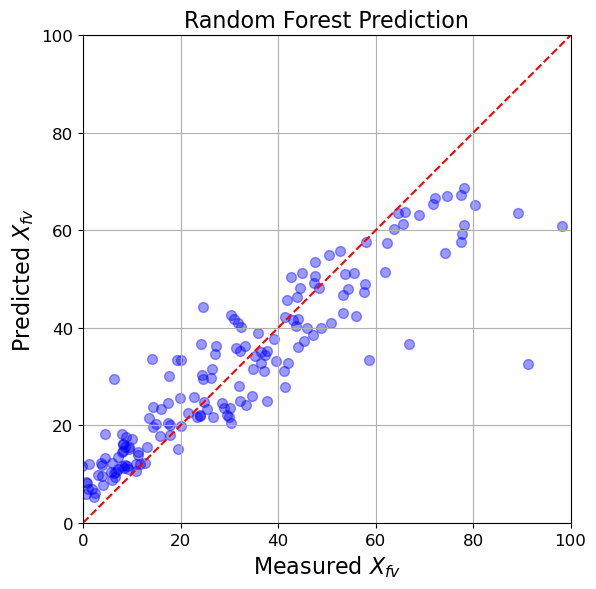

In [11]:
xline = np.linspace(0.0, 100, 100)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(Y, Y_pred, color='blue', alpha=0.4, s=50)
plt.plot(xline, xline, color='red', linestyle='--')

plt.title(f'Cross-Validation Predictions vs Actual')
plt.xlabel(r'Measured $X_{fv}$', fontsize=16)
plt.ylabel(r'Predicted $X_{fv}$', fontsize=16)

plt.xlim(0,100)
plt.ylim(0,100)
# plt.axes().set_aspect('equal')
ax.set_aspect('equal')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Random Forest Prediction", fontsize=16)

plt.grid(True)
plt.tight_layout()
# plt.savefig("figures/regression_plot.pdf", format="pdf")

plt.show()

In [12]:
importances = model_rf.feature_importances_
feature_names = X.columns

## Feature Importance Analysis

We extract and analyze the feature importances from the trained `RandomForestRegressor` model.  We use 3 alternative feature importance methods.
 
We store this information in a DataFrame, sort it in descending order, and print the results to identify the most influential features.

### I - Gini Index
The `feature_importances_` attribute provides the Gini importance scores, which indicate how much each feature contributes to the model's predictions. 

In [13]:
importances = model_rf.feature_importances_
feature_imp_gini = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_gini.head(10))

   Feature  Gini Importance
5      K2O         0.119062
16      Sr         0.106135
15      Rb         0.091291
44   Ca/Al         0.078672
47    K/Al         0.077671
1    Al2O3         0.041239
40      Mn         0.040887
3        S         0.039708
0      MgO         0.029472
50   Ti/Al         0.025734


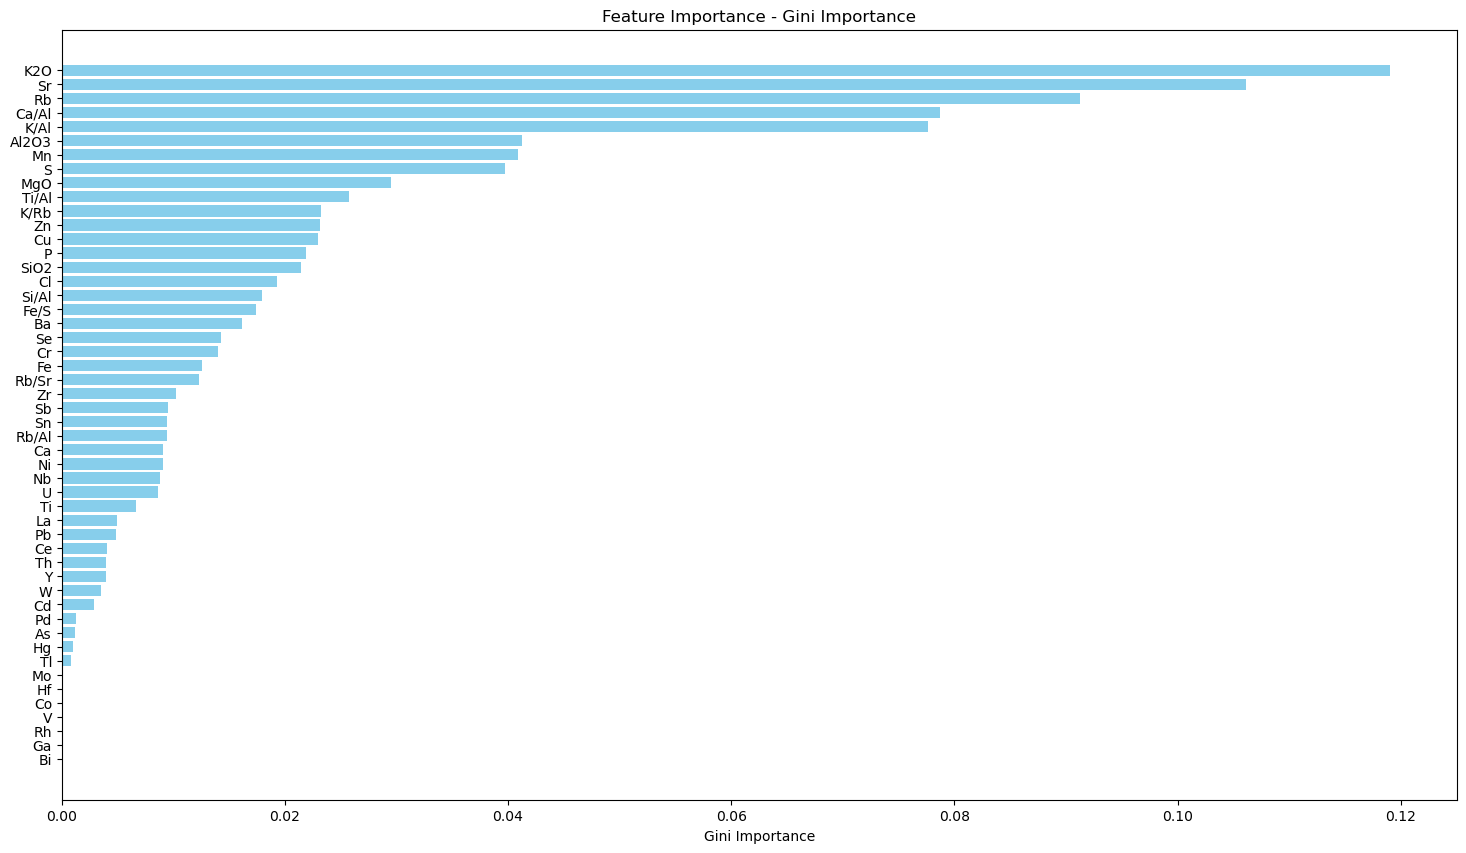

In [14]:
fig = plt.figure(figsize=(18, 10))


plt.barh(feature_imp_gini["Feature"].head(50), feature_imp_gini["Gini Importance"].head(50), color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [15]:
feature_imp_gini["Order Gini"] = np.arange(1, feature_imp_gini.shape[0]+1)
feature_imp_gini.head(5)

,Feature,Gini Importance,Order Gini
5,K2O,0.119062,1
16,Sr,0.106135,2
15,Rb,0.091291,3
44,Ca/Al,0.078672,4
47,K/Al,0.077671,5


### II - Permutation Test

we compute permutation importance for the trained `RandomForestRegressor` model.  
Permutation importance measures how much the model’s performance decreases when a feature’s values are randomly shuffled, providing an alternative view of feature importance.  
We use the `permutation_importance` function with 10 repeats (`n_repeats=10`).

In [16]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model_rf, X, Y, n_repeats=10, random_state=0, n_jobs=-1)

feature_imp_perm = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)
# print(feature_imp_perm)

feature_imp_perm["Order Perm"] = np.arange(1, feature_imp_perm.shape[0]+1)
feature_imp_perm.head(7)

,Feature,Permutation Importance,Order Perm
16,Sr,0.120438,1
5,K2O,0.106631,2
15,Rb,0.085971,3
44,Ca/Al,0.078827,4
47,K/Al,0.046084,5
3,S,0.033194,6
1,Al2O3,0.029856,7


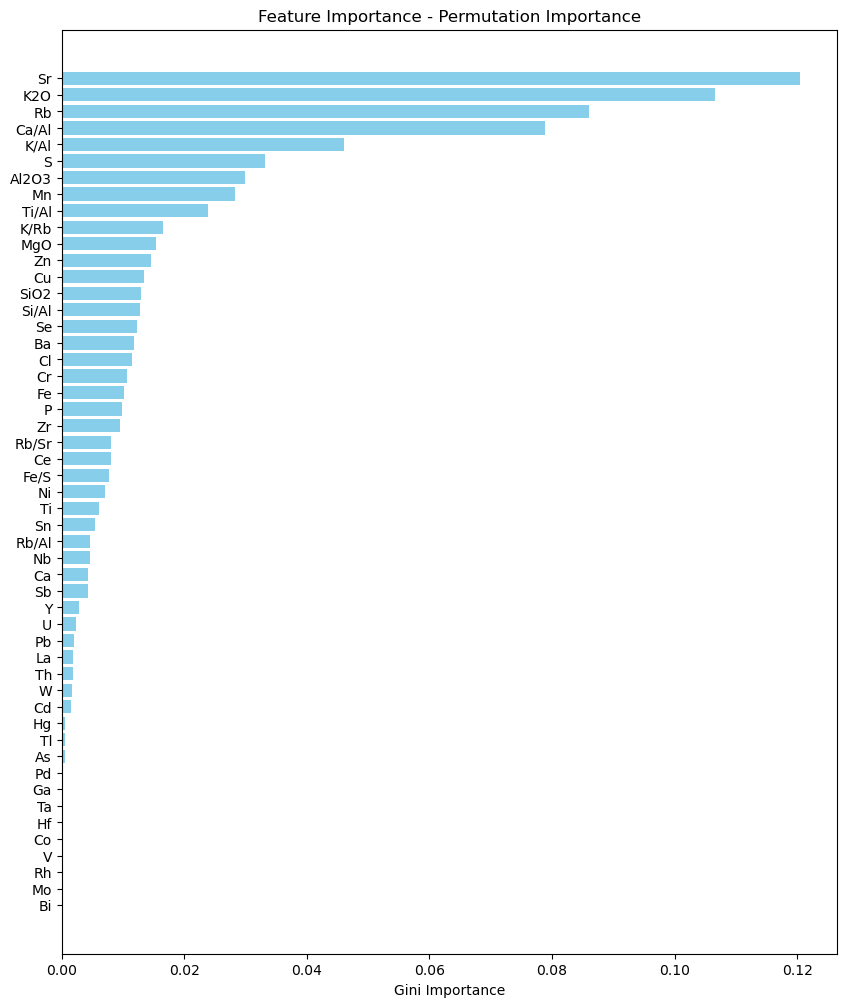

In [17]:
fig = plt.figure(figsize=(10, 12))

plt.barh(feature_imp_perm["Feature"], feature_imp_perm["Permutation Importance"], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

### III - Shapely values

This is a much better method, but we will see it gives very similar results. 

In [18]:
explainer = shap.TreeExplainer(model_rf)

In [19]:
# Calculate Shap values
choosen_instance = X.loc[[21]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 

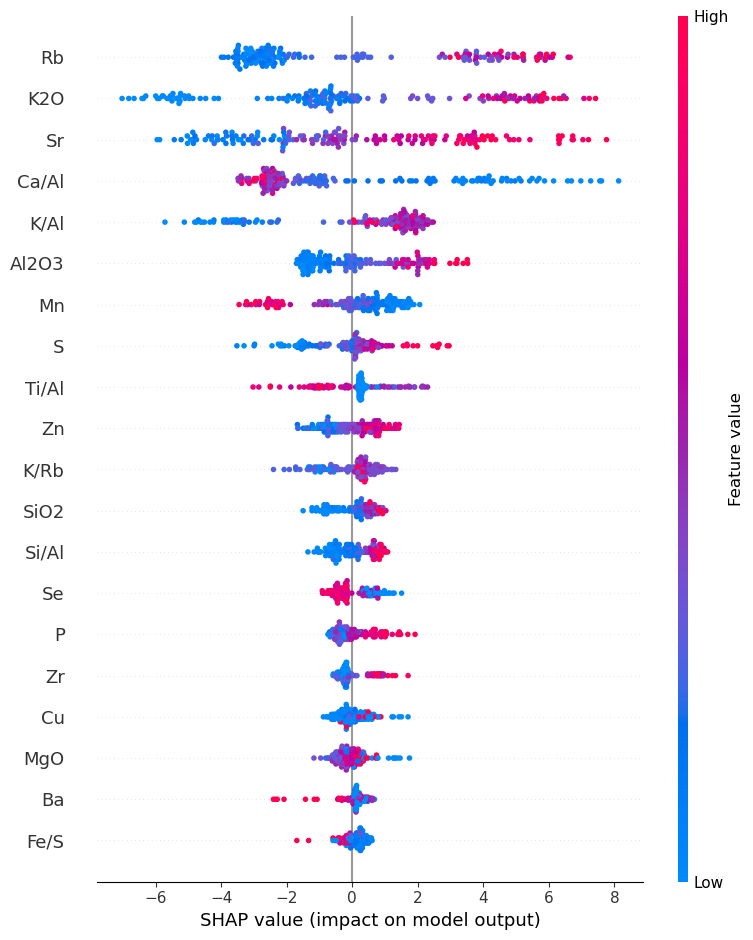

In [20]:
choosen_instance = X
shap_values = explainer.shap_values(choosen_instance)
shap.summary_plot(shap_values, X)

In [21]:
feature_order = np.array(X.columns[np.argsort(np.abs(shap_values).mean(0))])[::-1]
feature_shap = np.sort(np.abs(shap_values).mean(0))[::-1]
feature_imp_shap = pd.DataFrame({"Feature": feature_order,
                                  "Shap Value": feature_shap,
                                  "Order Shap": np.arange(1, X.shape[1]+1)})
feature_imp_shap.head()

,Feature,Shap Value,Order Shap
0,Rb,3.186665,1
1,K2O,3.093366,2
2,Sr,2.841662,3
3,Ca/Al,2.756856,4
4,K/Al,1.952966,5


# Summary

## Figures in the paper

In [22]:
df_summary = pd.merge(feature_imp_gini, feature_imp_perm, how="inner", on="Feature")
df_summary = pd.merge(df_summary, feature_imp_shap, how="inner", on="Feature")
df_summary["Order total"] = df_summary["Order Gini"] + df_summary["Order Perm"] + df_summary["Order Shap"]
df_summary = df_summary.sort_values(by = "Order total")

In [23]:
df_short = df_summary[["Feature", "Order Gini", "Order Perm", "Order Shap"]].set_index("Feature").head(10)
df_short = df_short.rename(columns={"Order Gini": "Gini Index", "Order Perm": "Permutation Index", "Order Shap": "SHAP Value"})

In [24]:
print(df_short)

         Gini Index  Permutation Index  SHAP Value
Feature                                           
K2O               1                  2           2
Sr                2                  1           3
Rb                3                  3           1
Ca/Al             4                  4           4
K/Al              5                  5           5
Al2O3             6                  7           6
Mn                7                  8           7
S                 8                  6           8
Ti/Al            10                  9           9
K/Rb             11                 10          11


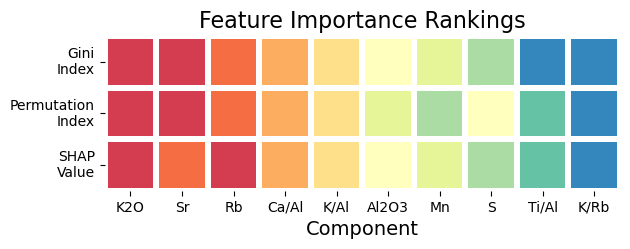

In [25]:
df_short
ax = sns.heatmap(df_short.transpose(), 
                 # annot=True, 
                 linewidth=4.0, 
                 cmap=sns.color_palette("Spectral", 9), 
                 square=True, cbar=False, annot_kws={"size":14})

ax.set_title("Feature Importance Rankings", fontsize=16)
ax.set_xlabel("Component", fontsize=14)
# ax.set_ylabel("Criteria", fontsize=14)

ax.set_yticklabels(["Gini\nIndex", "Permutation\nIndex", "SHAP\nValue"], rotation=0)

plt.tight_layout()
# plt.savefig("figures/rankings.pdf", format="pdf")

In [26]:
df_short.transpose()

Feature,K2O,Sr,Rb,Ca/Al,K/Al,Al2O3,Mn,S,Ti/Al,K/Rb
Gini Index,1,2,3,4,5,6,7,8,10,11
Permutation Index,2,1,3,4,5,7,8,6,9,10
SHAP Value,2,3,1,4,5,6,7,8,9,11


In [27]:
df_values = df_summary[["Feature", "Gini Importance", "Permutation Importance", "Shap Value"]].set_index("Feature")
df_values["Gini Importance (norm)"] = df_values["Gini Importance"] / np.sum(df_values["Gini Importance"])
df_values["Permutation Importance (norm)"] = df_values["Permutation Importance"] / np.sum(df_values["Permutation Importance"])
df_values["Shap Value (norm)"] = df_values["Shap Value"] / np.sum(df_values["Shap Value"])

df_values.head(5)

,Gini Importance,Permutation Importance,Shap Value,Gini Importance (norm),Permutation Importance (norm),Shap Value (norm)
Feature,,,,,,
K2O,0.119062,0.106631,3.093366,0.119062,0.134965,0.122477
Sr,0.106135,0.120438,2.841662,0.106135,0.152442,0.112511
Rb,0.091291,0.085971,3.186665,0.091291,0.108816,0.126171
Ca/Al,0.078672,0.078827,2.756856,0.078672,0.099774,0.109154
K/Al,0.077671,0.046084,1.952966,0.077671,0.058330,0.077325


In [28]:
df_values.index

Index(['K2O', 'Sr', 'Rb', 'Ca/Al', 'K/Al', 'Al2O3', 'Mn', 'S', 'Ti/Al', 'K/Rb',
       'Zn', 'MgO', 'SiO2', 'Cu', 'Si/Al', 'Se', 'P', 'Ba', 'Cl', 'Zr', 'Fe/S',
       'Fe', 'Cr', 'Rb/Sr', 'Rb/Al', 'Ni', 'Sn', 'Ti', 'Nb', 'Ce', 'Ca', 'Sb',
       'U', 'La', 'Pb', 'Y', 'Th', 'W', 'Cd', 'As', 'Pd', 'Hg', 'Tl', 'Ga',
       'Co', 'Mo', 'Hf', 'V', 'Rh', 'Bi', 'Ta'],
      dtype='object', name='Feature')

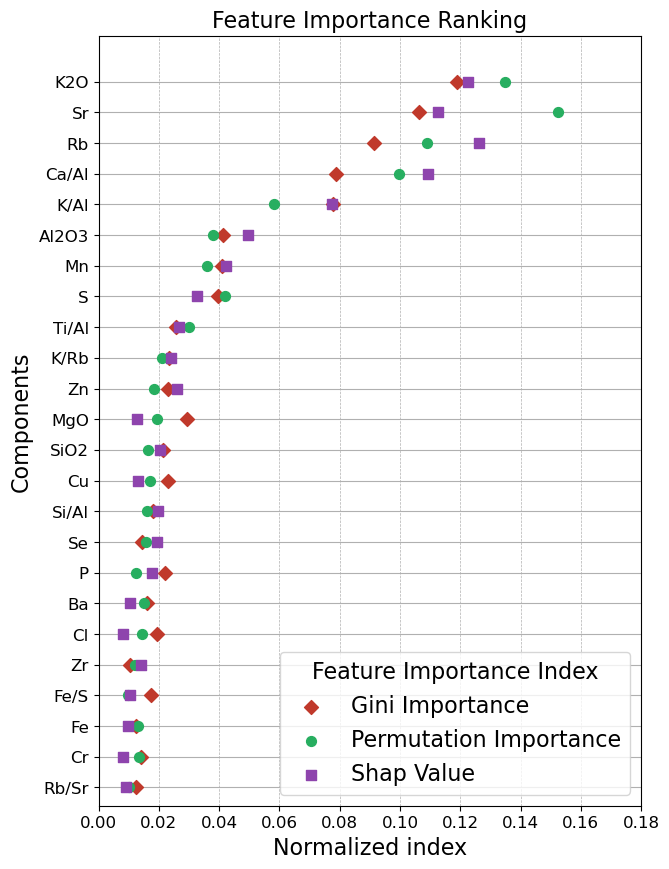

In [29]:
fig, ax_ranking = plt.subplots(figsize=(7,10))

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.grid(axis = 'x', linestyle = '--', linewidth = 0.5)
plt.grid(axis = 'y')

plt.scatter(df_values["Gini Importance (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Gini Importance", marker="D", c="#c0392b", s=50, zorder = 100)
plt.scatter(df_values["Permutation Importance (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Permutation Importance", marker="o", c="#27ae60", s=50, zorder = 100)
plt.scatter(df_values["Shap Value (norm)"], np.arange(df_values.shape[0]+1, 1, -1), label="Shap Value", marker="s", c="#8e44ad", s=50, zorder = 100)

plt.xlabel("Normalized index", fontsize=16)
plt.ylabel("Components", fontsize=16)
ax_ranking.set_yticks(np.arange(df_values.shape[0]+1, 1, -1), df_values.index)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0,0.18)
plt.ylim(28.4, 53.5)
plt.title("Feature Importance Ranking", fontsize=16)

leg = plt.legend(title="Feature Importance Index", loc="lower right", fontsize=16, title_fontsize=16)

# plt.savefig("figures/importance.pdf", format="pdf")